In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

db_params = {
    'dbname': 'SQLTEST',
    'user': 'postgres',
    'password': 'Admin',
    'host': 'localhost',
    'port': '5432',
}

In [3]:
query = """
WITH sales_data AS (
    SELECT 
        c.id AS category_id,
        c.name AS category_name,
        SUM(o.total_amount) AS total_sales,
        'Current Period' AS period
    FROM 
        public.groups_carts gc
    JOIN 
        public.orders o 
        ON gc.id = o.groups_carts_id
    JOIN 
        public.group_cart_variations gcv
        ON gc.id = gcv.group_cart_id
    JOIN 
        public.product_variations pv
        ON gcv.product_variation_id = pv.id
    JOIN 
        public.products p
        ON pv.product_id = p.id
    JOIN 
        public.product_names pn
        ON p.name_id = pn.id
    JOIN 
        public.categories c
        ON pn.category_id = c.id
    WHERE 
        o.created_at BETWEEN '2024-09-14 17:52:36.368747' AND '2024-12-13 17:52:36.368747'
    GROUP BY 
        c.id, c.name

    UNION ALL

    SELECT 
        c.id AS category_id,
        c.name AS category_name,
        SUM(o.total_amount) AS total_sales,
        'Previous Period' AS period
    FROM 
        public.groups_carts gc
    JOIN 
        public.orders o 
        ON gc.id = o.groups_carts_id
    JOIN 
        public.group_cart_variations gcv
        ON gc.id = gcv.group_cart_id
    JOIN 
        public.product_variations pv
        ON gcv.product_variation_id = pv.id
    JOIN 
        public.products p
        ON pv.product_id = p.id
    JOIN 
        public.product_names pn
        ON p.name_id = pn.id
    JOIN 
        public.categories c
        ON pn.category_id = c.id
    WHERE 
        o.created_at BETWEEN '2024-06-16 17:52:36.368747' AND '2024-09-14 17:52:36.368747'
    GROUP BY 
        c.id, c.name
)

SELECT 
    current.category_id,
    current.category_name,
    current.total_sales AS current_sales,
    previous.total_sales AS previous_sales,
    CASE 
        WHEN previous.total_sales = 0 THEN NULL
        ELSE ((current.total_sales - previous.total_sales) / previous.total_sales) * 100
    END AS sales_growth_percentage
FROM 
    (SELECT category_id, category_name, total_sales 
     FROM sales_data 
     WHERE period = 'Current Period') AS current
LEFT JOIN 
    (SELECT category_id, category_name, total_sales 
     FROM sales_data 
     WHERE period = 'Previous Period') AS previous
ON current.category_id = previous.category_id
ORDER BY 
    current.category_name;
"""

In [4]:
def fetch_data(db_params, query):
    conn = psycopg2.connect(**db_params)
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df


In [5]:
data = fetch_data(db_params, query)

C:\Users\huawei\AppData\Local\Temp\ipykernel_10120\2740523370.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [6]:
data.fillna(0, inplace=True)  


# Plot 1: Bar Chart - Current vs Previous Sales

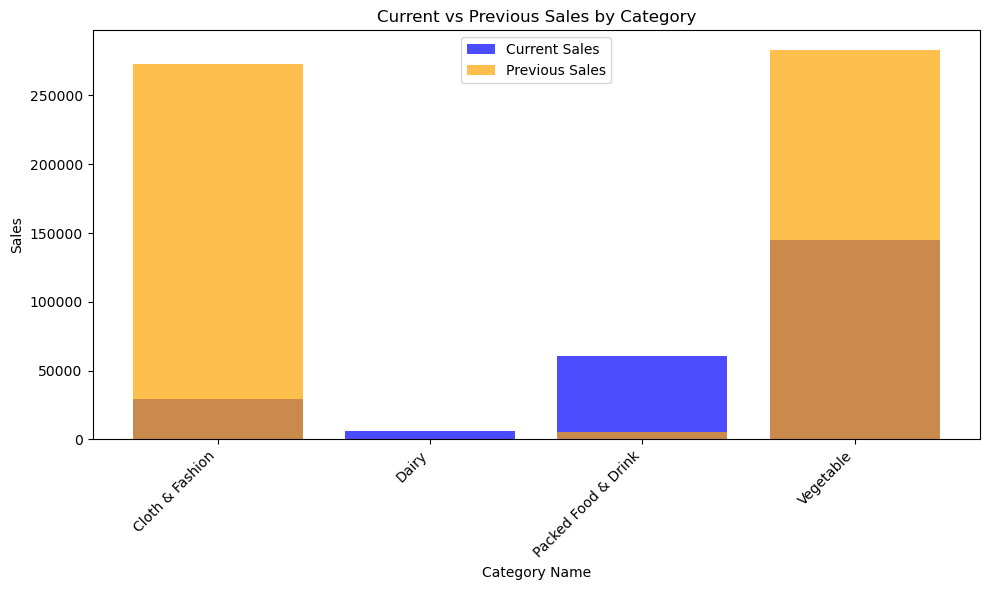

In [7]:
plt.figure(figsize=(10, 6))
x = data['category_name']
y1 = data['current_sales']
y2 = data['previous_sales']

plt.bar(x, y1, label='Current Sales', alpha=0.7, color='blue')
plt.bar(x, y2, label='Previous Sales', alpha=0.7, color='orange')
plt.xlabel('Category Name')
plt.ylabel('Sales')
plt.title('Current vs Previous Sales by Category')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Line Chart - Sales Growth Percentage

c:\Users\huawei\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\huawei\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


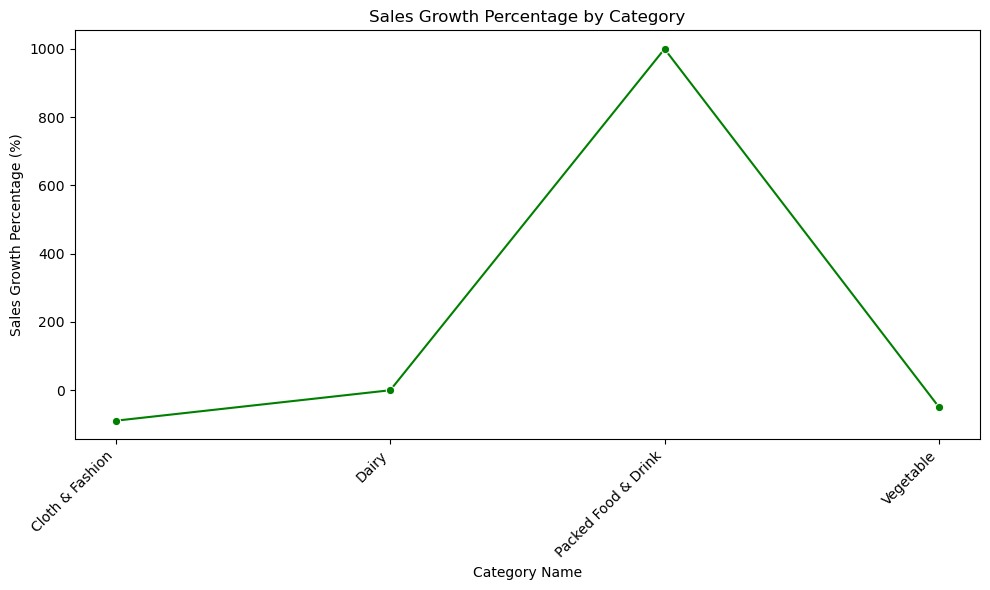

In [8]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='category_name', y='sales_growth_percentage', data=data, marker='o', color='green')
plt.xlabel('Category Name')
plt.ylabel('Sales Growth Percentage (%)')
plt.title('Sales Growth Percentage by Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Plot 3: Pie Chart - Contribution of Current Sales by Category

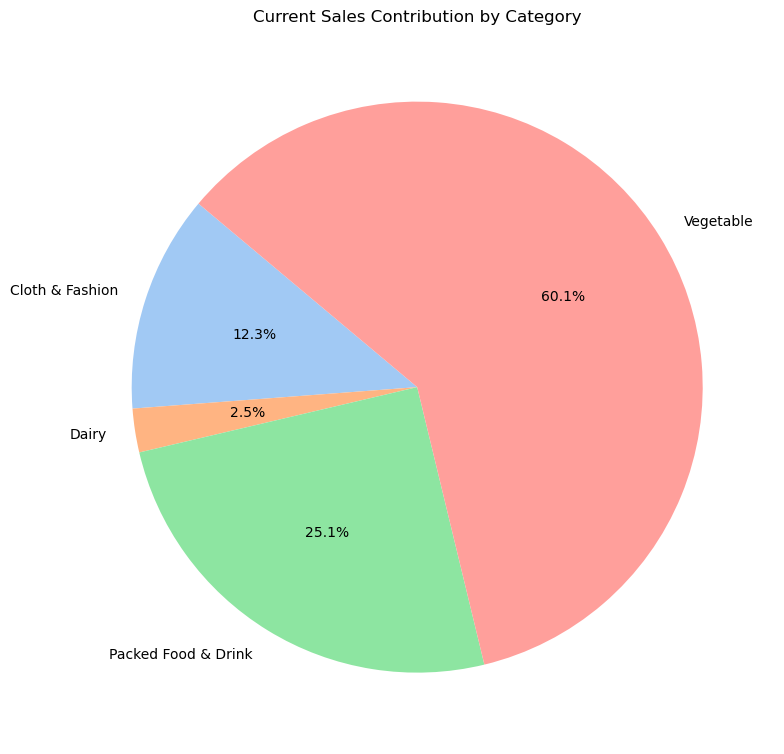

In [9]:
plt.figure(figsize=(8, 8))
plt.pie(data['current_sales'], labels=data['category_name'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Current Sales Contribution by Category')
plt.tight_layout()
plt.show()

# Plot 4: Scatter Plot - Current Sales vs Sales Growth Percentage

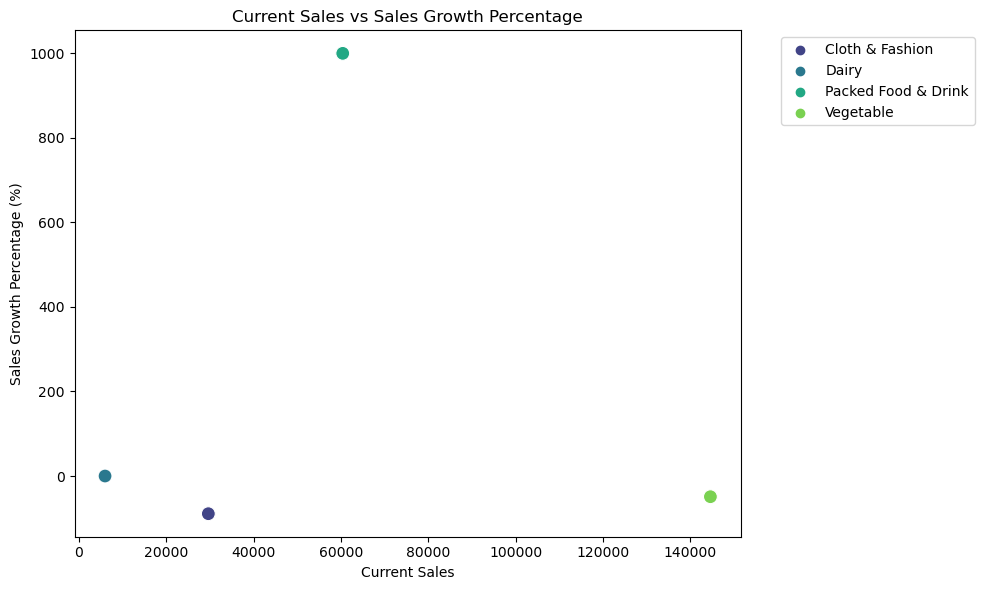

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='current_sales', y='sales_growth_percentage', hue='category_name', data=data, palette='viridis', s=100)
plt.xlabel('Current Sales')
plt.ylabel('Sales Growth Percentage (%)')
plt.title('Current Sales vs Sales Growth Percentage')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()